In [127]:
from pydub import AudioSegment
from pathlib import Path

input_dir = Path("../data/dtw_test_rec")


files = list(input_dir.rglob("*.m4a"))
for file in files:
    save_file = Path(*file.parts[:4]).with_suffix(".wav")
    audio = AudioSegment.from_file(file, format="m4a")
    audio.export(save_file, format="wav")

print("Conversion complete!")


Conversion complete!


In [131]:
import numpy as np
def dp(dist_mat):
    """
    Find minimum-cost path through matrix `dist_mat` using dynamic programming.

    The cost of a path is defined as the sum of the matrix entries on that
    path. See the following for details of the algorithm:

    - http://en.wikipedia.org/wiki/Dynamic_time_warping
    - https://www.ee.columbia.edu/~dpwe/resources/matlab/dtw/dp.m

    The notation in the first reference was followed, while Dan Ellis's code
    (second reference) was used to check for correctness. Returns a list of
    path indices and the cost matrix.
    """

    N, M = dist_mat.shape
    
    # Initialize the cost matrix
    cost_mat = np.zeros((N + 1, M + 1))
    for i in range(1, N + 1):
        cost_mat[i, 0] = np.inf
    for i in range(1, M + 1):
        cost_mat[0, i] = np.inf

    # Fill the cost matrix while keeping traceback information
    traceback_mat = np.zeros((N, M))
    for i in range(N):
        for j in range(M):
            penalty = [
                cost_mat[i, j],      # match (0)
                cost_mat[i, j + 1],  # insertion (1)
                cost_mat[i + 1, j]]  # deletion (2)
            i_penalty = np.argmin(penalty)
            cost_mat[i + 1, j + 1] = dist_mat[i, j] + penalty[i_penalty]
            traceback_mat[i, j] = i_penalty

    # Traceback from bottom right
    i = N - 1
    j = M - 1
    path = [(i, j)]
    while i > 0 or j > 0:
        tb_type = traceback_mat[i, j]
        if tb_type == 0:
            # Match
            i = i - 1
            j = j - 1
        elif tb_type == 1:
            # Insertion
            i = i - 1
        elif tb_type == 2:
            # Deletion
            j = j - 1
        path.append((i, j))

    # Strip infinity edges from cost_mat before returning
    cost_mat = cost_mat[1:, 1:]
    return (path[::-1], cost_mat)

In [162]:
import torchaudio
from torchaudio.transforms import MelSpectrogram
import matplotlib.pyplot as plt
import numpy as np
import torch

In [170]:


def get_frame_num(s, sample_rate, hop_length):
    frames_per_second = sample_rate / hop_length  # Number of frames per second
    return int(np.round(s * frames_per_second ))  # Convert ms → frames

def plot_waveform(waveform, sr, title="Waveform", ax=None, speech_timestamps=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)

    if speech_timestamps:
        start_time = speech_timestamps[0]['start']
        end_time = speech_timestamps[0]['end']
        
        # Plot vertical lines for start and end frames
        ax.axvline(x=start_time, color='r', linestyle='--', label='Start Frame')
        ax.axvline(x=end_time, color='g', linestyle='--', label='End Frame')

    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)


def plot_spectrogram(specgram, title=None, ylabel="feature dimensions", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(specgram, aspect="auto", origin="lower")

In [186]:
from silero_vad import load_silero_vad, read_audio, get_speech_timestamps
import numpy as np 
import torchaudio
from torchaudio.transforms import MelSpectrogram
import scipy.spatial.distance as dist

model = load_silero_vad()

input_dir = Path("../data/dtw_test_rec")
output_dir = Path("../data/dtw_test_rec/alignments")  
output_dir.mkdir(parents=True, exist_ok=True)  


waveforms = []
sequences = []

files = list(input_dir.rglob("*.wav"))
for file in files:
    wav = read_audio(file)
    speech_timestamps = get_speech_timestamps(wav, model, return_seconds=True)

    waveform, sample_rate = torchaudio.load(file)
    waveforms.append(waveform)
    n_fft = int(0.025*sample_rate)      
    hop_length = int(0.01*sample_rate)  

    transform = MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=40
    )
    mel_spectogram = transform(waveform/1.0)
    mel_spectogram = mel_spectogram.squeeze().numpy() 
    start_frame = get_frame_num(speech_timestamps[0]['start'], sample_rate, hop_length)
    end_frame = get_frame_num(speech_timestamps[0]['end'], sample_rate, hop_length)
   
    frame_list = [start_frame, end_frame]

    # Save to a .list file named after the current .wav file
    list_filename = output_dir / f"{file.stem}.list"  # Use the .wav filename without extension
    with open(list_filename, 'a') as f:  # Open the file in append mode
        f.write(f"{frame_list[0]} {frame_list[1]}\n")  # Write the frame start and end

    mel_spectogram = mel_spectogram[:, start_frame:end_frame]


    # plot_waveform(waveform, sample_rate, title="Original waveform", speech_timestamps=speech_timestamps)
    
    log_mel_spec = np.log(mel_spectogram  + 1e-10)
    min_finite = np.min(log_mel_spec[np.isfinite(log_mel_spec)])
    log_mel_spec[np.isinf(log_mel_spec)] = min_finite
    sequences.append(log_mel_spec)

norm_distance_mat = np.zeros((len(sequences), len(sequences)))
distance_mat = np.zeros((len(sequences), len(sequences)))
for i in range(len(sequences)):
    for j in range(i+1, len(sequences)):
        dist_mat = dist.cdist(sequences[i].T, sequences[j].T, "cosine")
        path, cost_mat = dp(dist_mat)
        distance_mat[i, j] = round(cost_mat[-1, -1], 4)
        length = sequences[i].shape[1] + sequences[j].shape[1]
        norm_distance_mat[i, j] = round(cost_mat[-1, -1]/length, 4)
        
print(distance_mat)
print()
print(norm_distance_mat)

[[0.     1.7257 6.7937 2.9417 2.948 ]
 [0.     0.     4.6678 1.9641 2.9714]
 [0.     0.     0.     3.1956 4.2191]
 [0.     0.     0.     0.     0.9996]
 [0.     0.     0.     0.     0.    ]]

[[0.     0.0102 0.0453 0.0226 0.0227]
 [0.     0.     0.0292 0.014  0.0212]
 [0.     0.     0.     0.0266 0.0352]
 [0.     0.     0.     0.     0.01  ]
 [0.     0.     0.     0.     0.    ]]


In [224]:
import torchaudio
from pathlib import Path

input_dir = Path("../data/dtw_test_rec/wav")
output_dir = Path("../data/dtw_test_rec/cut_wav")  # Save back to the same directory
output_dir.mkdir(parents=True, exist_ok=True)

files = list(input_dir.rglob("*.wav"))
for file in files:
    wav = read_audio(file)
    speech_timestamps = get_speech_timestamps(wav, model, return_seconds=True)
    print(speech_timestamps)
    waveform, sample_rate = torchaudio.load(file)
    
    # Loop through the timestamps and extract the audio segments
    for timestamp in speech_timestamps:
        start_time = timestamp['start']
        end_time = timestamp['end']
        
        # Convert start and end times to sample indices
        start_frame = int(start_time * sample_rate)
        end_frame = int(end_time * sample_rate)
        
        # Slice the waveform
        waveform_slice = waveform[:, start_frame:end_frame]

        new_file = output_dir / Path(file.stem).with_suffix(".wav")
        torchaudio.save(new_file, waveform_slice, sample_rate)

    print(f"Processed and saved sliced files for: {new_file}")


[{'start': 1.0, 'end': 1.8}]
Processed and saved sliced files for: ../data/dtw_test_rec/cut_wav/appel1.wav
[{'start': 0.7, 'end': 1.6}]
Processed and saved sliced files for: ../data/dtw_test_rec/cut_wav/appel2.wav
[{'start': 0.7, 'end': 1.4}]
Processed and saved sliced files for: ../data/dtw_test_rec/cut_wav/peer.wav
[{'start': 1.4, 'end': 1.9}]
Processed and saved sliced files for: ../data/dtw_test_rec/cut_wav/kyle_appel.wav
[{'start': 1.8, 'end': 2.3}]
Processed and saved sliced files for: ../data/dtw_test_rec/cut_wav/reuben_appel.wav
[{'start': 0.7, 'end': 1.3}, {'start': 1.5, 'end': 2.0}]
Processed and saved sliced files for: ../data/dtw_test_rec/cut_wav/appel_peer.wav


In [227]:
import torchaudio
from pathlib import Path

file_in = Path("../data/dtw_test_rec/wav/appel_peer.wav")


wav = read_audio(file_in)
speech_timestamps = get_speech_timestamps(wav, model, return_seconds=True)
print(speech_timestamps)
waveform, sample_rate = torchaudio.load(file)


for i, timestamp in enumerate(speech_timestamps):
    start_time = timestamp['start']
    end_time = timestamp['end']
    
    # Convert start and end times to sample indices
    start_frame = int(start_time * sample_rate)
    end_frame = int(end_time * sample_rate)
    
    # Slice the waveform
    waveform_slice = waveform[:, start_frame:end_frame]
    file_out = Path(f"../data/dtw_test_rec/cut_wav/appel_peer{i}.wav")

    torchaudio.save(file_out, waveform_slice, sample_rate)

# print(f"Processed and saved sliced files for: {new_file}")

[{'start': 0.7, 'end': 1.3}, {'start': 1.5, 'end': 2.0}]


In [211]:
from tqdm import tqdm
from torchaudio.pipelines import HUBERT_BASE, HUBERT_LARGE, HUBERT_XLARGE
import numpy as np
from pathlib import Path
import torch
import torchaudio

input_dir = "../data/dtw_test_rec/cut_wav"
output_dir = "../data/dtw_test_rec/encodings"

def encode_audio(input_dir, output_dir):
        bundle = HUBERT_BASE
        model = bundle.get_model()
        model.eval()
        output_dir = Path(output_dir) / "hubert_base"

        audios = [a for a in Path(input_dir).rglob(f"*wav")]
        for audio_path in tqdm(audios, desc="Encoding Waveforms"):
            waveform, sample_rate = torchaudio.load(str(audio_path))

            transform = torchaudio.transforms.Resample(
                orig_freq=sample_rate, 
                new_freq=bundle.sample_rate
            )
            waveform = transform(waveform)

            with torch.no_grad():
                features, _ = model.extract_features(waveform, num_layers=7)
            
            encoding = features[7- 1].squeeze(0).cpu().numpy()

            rel_path = Path(audio_path).relative_to(Path(input_dir))
            npy_path = Path(output_dir) / f"7" / rel_path.with_suffix(".npy")

            npy_path.parent.mkdir(parents=True, exist_ok=True)

            np.save(npy_path, encoding)

encode_audio(input_dir, output_dir)

Encoding Waveforms: 100%|██████████| 5/5 [00:00<00:00, 10.95it/s]


In [213]:
from silero_vad import load_silero_vad, read_audio, get_speech_timestamps
import numpy as np 
import torchaudio
from torchaudio.transforms import MelSpectrogram
import scipy.spatial.distance as dist
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

model = load_silero_vad()

input_dir = Path("../data/dtw_test_rec/encodings/hubert_base/7")


files = list(input_dir.rglob("*.npy"))

features = []
for file in files:
    encodings = torch.from_numpy(np.load(file))
    if len(encodings.shape) == 1: # if only one dimension, add a dimension
        features.append(encodings.unsqueeze(0))
    else:
        features.append(encodings)

stacked_features = torch.cat(features, dim=0)
scaler = StandardScaler()
scaler.fit(stacked_features) # (n_samples, n_features)
normalized_features = []
flat_norm_features = []
for feature in features:
    norm_feature = torch.from_numpy(scaler.transform(feature))
    normalized_features.append(norm_feature) 
    flat_norm_feature = norm_feature.squeeze().numpy()
    flat_norm_features.append(flat_norm_feature)


norm_distance_mat = np.zeros((len(flat_norm_features), len(flat_norm_features)))
distance_mat = np.zeros((len(flat_norm_features), len(flat_norm_features)))
for i in range(len(flat_norm_features)):
    for j in range(i+1, len(flat_norm_features)):
        dist_mat = dist.cdist(flat_norm_features[i], flat_norm_features[j], "cosine")
        path, cost_mat = dp(dist_mat)
        distance_mat[i, j] = round(cost_mat[-1, -1], 4)

        length = flat_norm_features[i].shape[1] + flat_norm_features[j].shape[1]
        print(f"Normalized Distance between {files[i].stem} and {files[j].stem}: {round(cost_mat[-1, -1]/length, 4)}")
        norm_distance_mat[i, j] = round(cost_mat[-1, -1]/length, 4)
    print()
        
print(distance_mat)
print()
print(norm_distance_mat)

Normalized Distance between kyle_appel and appel2: 0.0236
Normalized Distance between kyle_appel and appel1: 0.0207
Normalized Distance between kyle_appel and peer: 0.0203
Normalized Distance between kyle_appel and reuben_appel: 0.006

Normalized Distance between appel2 and appel1: 0.0136
Normalized Distance between appel2 and peer: 0.0245
Normalized Distance between appel2 and reuben_appel: 0.0247

Normalized Distance between appel1 and peer: 0.0221
Normalized Distance between appel1 and reuben_appel: 0.0207

Normalized Distance between peer and reuben_appel: 0.0216


[[ 0.     36.2941 31.7789 31.1299  9.2805]
 [ 0.      0.     20.8376 37.7009 37.9407]
 [ 0.      0.      0.     33.8816 31.7768]
 [ 0.      0.      0.      0.     33.1635]
 [ 0.      0.      0.      0.      0.    ]]

[[0.     0.0236 0.0207 0.0203 0.006 ]
 [0.     0.     0.0136 0.0245 0.0247]
 [0.     0.     0.     0.0221 0.0207]
 [0.     0.     0.     0.     0.0216]
 [0.     0.     0.     0.     0.    ]]


/tmp/ipykernel_5785/677689724.py:20: RuntimeWarning: divide by zero encountered in log
  log_mel_spec = np.log(mel_spectogram)
/tmp/ipykernel_5785/677689724.py:20: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  log_mel_spec = np.log(mel_spectogram)


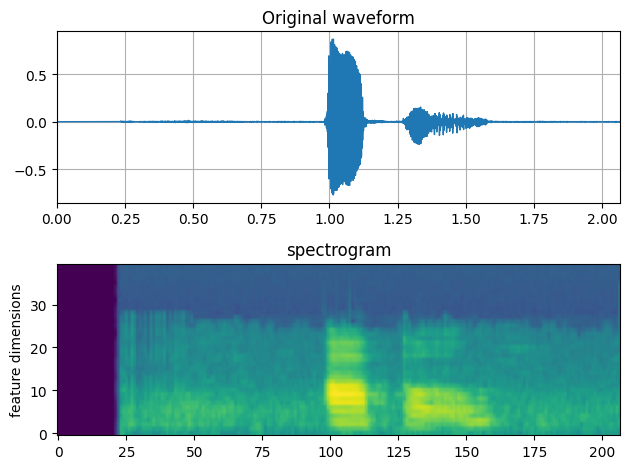

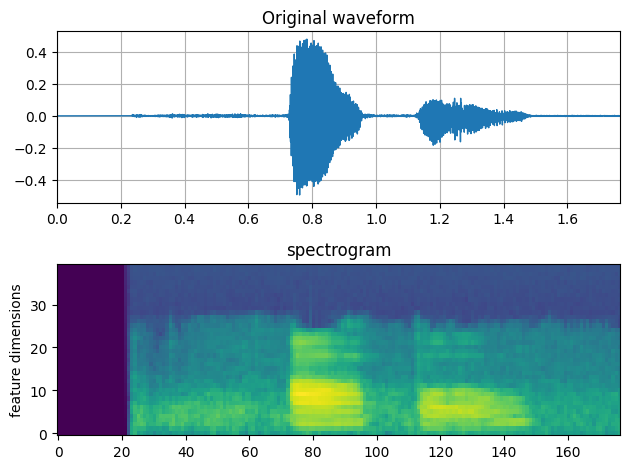

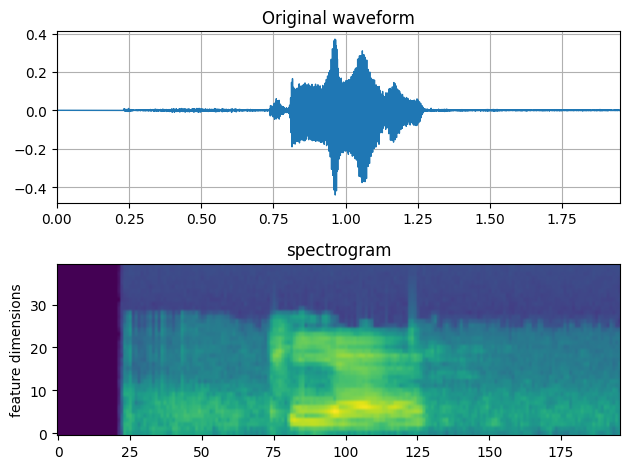

In [87]:
input_dir = Path("../data/dtw_test_rec")


files = list(input_dir.rglob("*.wav"))
waveforms=[]
sequences=[]
for file in files:
    waveform, sample_rate = torchaudio.load(file)
    waveforms.append(waveform)
    n_fft = int(0.025*sample_rate)      
    hop_length = int(0.01*sample_rate)  

    transform = MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=40
    )
    mel_spectogram = transform(waveform/1.0)
    log_mel_spec = np.log(mel_spectogram)
    log_mel_spec_np = log_mel_spec.squeeze().numpy() 
    min_finite = np.min(log_mel_spec_np[np.isfinite(log_mel_spec_np)])
    log_mel_spec_np[np.isinf(log_mel_spec_np)] = min_finite
    sequences.append(log_mel_spec_np)

    fig, axs = plt.subplots(2, 1)
    plot_waveform(waveform, sample_rate, title="Original waveform", ax=axs[0])
    plot_spectrogram(log_mel_spec_np, title="spectrogram", ax=axs[1])
    fig.tight_layout()
    plt.show()

[[0.     1.6275 5.6821]
 [1.6275 0.     5.3084]
 [5.6821 5.3084 0.    ]]


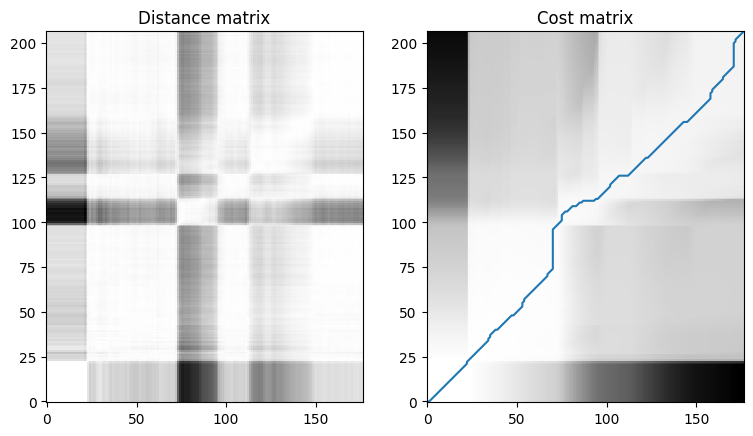

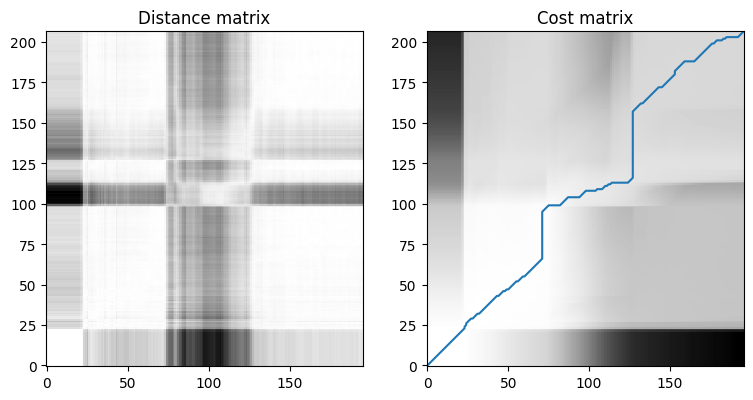

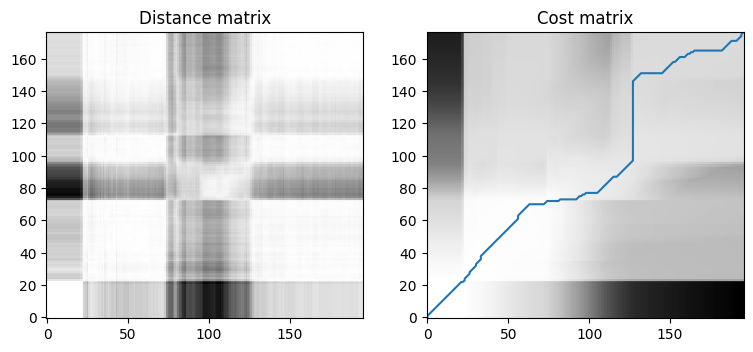

In [112]:
import scipy.spatial.distance as dist
distance_mat = np.zeros((len(sequences), len(sequences)))
for i in range(len(sequences)):
    for j in range(i+1, len(sequences)):
        dist_mat = dist.cdist(sequences[i].T, sequences[j].T, "cosine")
        path, cost_mat = dp(dist_mat)
        distance_mat[i, j] = round(cost_mat[-1, -1], 4)

        plt.figure(figsize=(9, 5))
        plt.subplot(121)
        plt.title("Distance matrix")
        plt.imshow(dist_mat, cmap=plt.cm.binary, interpolation="nearest", origin="lower")
        plt.subplot(122)
        plt.title("Cost matrix")
        plt.imshow(cost_mat, cmap=plt.cm.binary, interpolation="nearest", origin="lower")
        x_path, y_path = zip(*path)
        plt.plot(y_path, x_path);
        
distance_mat += distance_mat.T  
print(distance_mat)

Appel vs Ap-pel

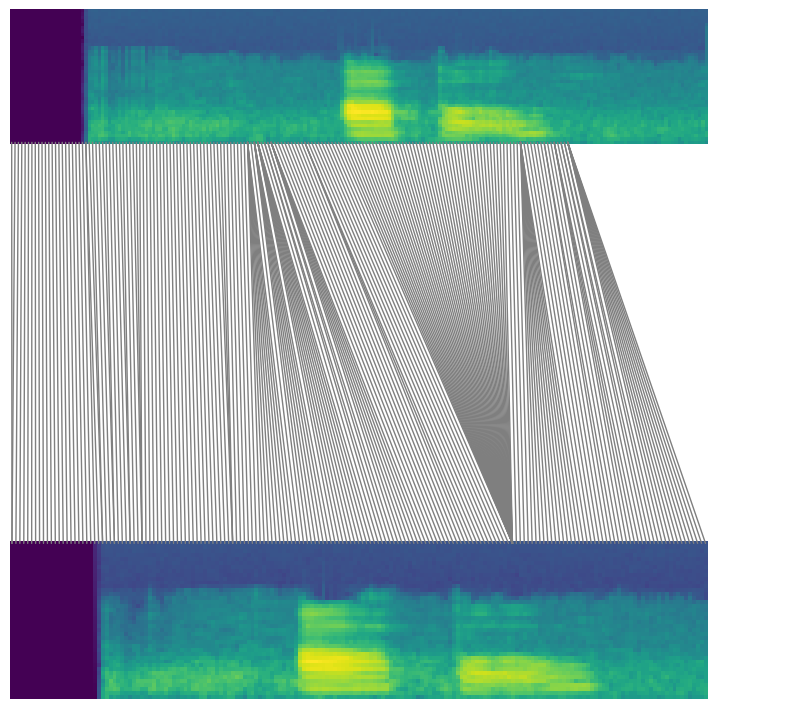

In [109]:
from matplotlib.patches import ConnectionPatch
fig = plt.figure(figsize=(9, 10))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(313)

ax1.imshow(sequences[0], origin="lower", interpolation="nearest")
ax2.imshow(sequences[1], origin="lower", interpolation="nearest")
ax1.axis("off")
ax2.axis("off")

for x_i, y_j in path:
    con = ConnectionPatch(
        xyA=(x_i, 0), xyB=(y_j, sequences[0].shape[0] - 1), coordsA="data", coordsB="data",
        axesA=ax1, axesB=ax2, color="C7"
        )
    ax2.add_artist(con)

Appel vs Peer

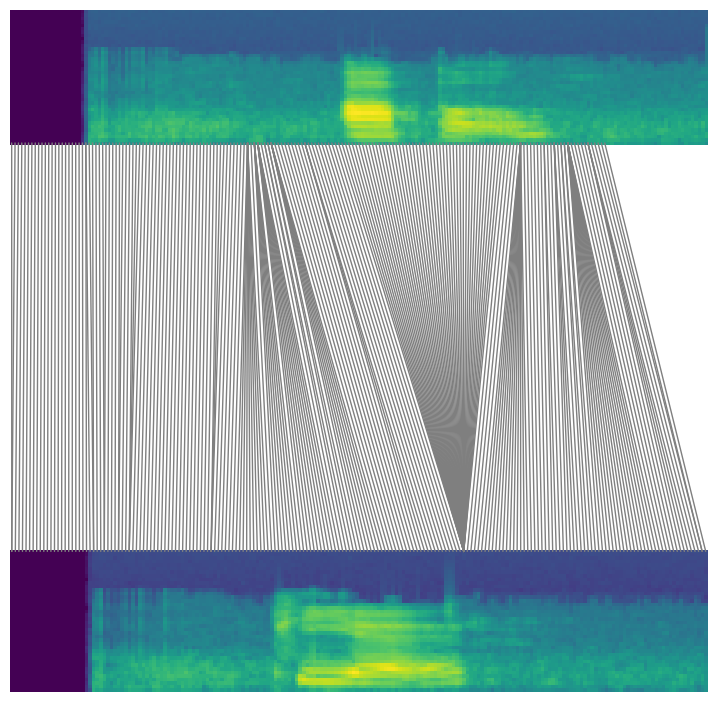

In [110]:
from matplotlib.patches import ConnectionPatch
fig = plt.figure(figsize=(9, 10))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(313)

ax1.imshow(sequences[0], origin="lower", interpolation="nearest")
ax2.imshow(sequences[2], origin="lower", interpolation="nearest")
ax1.axis("off")
ax2.axis("off")

for x_i, y_j in path:
    con = ConnectionPatch(
        xyA=(x_i, 0), xyB=(y_j, sequences[0].shape[0] - 1), coordsA="data", coordsB="data",
        axesA=ax1, axesB=ax2, color="C7"
        )
    ax2.add_artist(con)

In [176]:
query = '../data/dtw_test_rec/appel1.wav'
files = ['../data/dtw_test_rec/appel2.wav', '../data/dtw_test_rec/peer.wav', '../data/dtw_test_rec/kyle_appel.wav', '../data/dtw_test_rec/reuben_appel.wav']

waveform_x, sample_rate = torchaudio.load(query)

n_fft = int(0.025 * sample_rate)      
hop_length = int(0.01 * sample_rate)  

transform = MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    hop_length=hop_length,
    n_mels=40
)
mel_spectogram_x = transform(waveform_x / 1.0)
mel_spectogram_x = mel_spectogram_x.squeeze().numpy()

min_finite = np.min(mel_spectogram_x[np.isfinite(mel_spectogram_x)])
mel_spectogram_x[np.isinf(mel_spectogram_x)] = min_finite

log_mel_spec_x = np.log(mel_spectogram_x + 1e-10) 

x_seq = log_mel_spec_x.T

for file in files:
    print(f"Reading: {file.split('/')[3]}")
    waveform_y, sample_rate = torchaudio.load(file)
    n_fft = int(0.025 * sample_rate)      
    hop_length = int(0.01 * sample_rate)  

    transform = MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=40
    )
    mel_spectogram_y = transform(waveform_y / 1.0)
    mel_spectogram_y = mel_spectogram_y.squeeze().numpy()
    
    min_finite = np.min(mel_spectogram_y[np.isfinite(mel_spectogram_y)])
    mel_spectogram_y[np.isinf(mel_spectogram_y)] = min_finite

    log_mel_spec_y = np.log(mel_spectogram_y + 1e-10) 
    
    y_seq = log_mel_spec_y.T

    dist_mat = dist.cdist(x_seq, y_seq, "cosine")
    path, cost_mat = dp(dist_mat)
    print(f"Alignment cost: {cost_mat[-1, -1]:.4f}")
    M = y_seq.shape[0]
    N = x_seq.shape[0]
    print(f"Normalized alignment cost: {cost_mat[-1, -1] / (M + N):.8f}\n")


Reading: appel2.wav
Alignment cost: 1.6271
Normalized alignment cost: 0.00423736

Reading: peer.wav
Alignment cost: 5.6822
Normalized alignment cost: 0.01409963

Reading: kyle_appel.wav
Alignment cost: 2.5082
Normalized alignment cost: 0.00561122

Reading: reuben_appel.wav
Alignment cost: 3.7561
Normalized alignment cost: 0.00704711

